In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import george
from george.modeling import Model
import healpy as hp
from healpy.newvisufunc import projview
import os
import sys
sys.path.insert(0, '/home/aew492/gaia-quasars-lss/code')
import maps

Configuration file not found:

    /home/aew492/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.


#### functions

In [3]:
def plot_map(map, title=None, unit=None, projection_type='mollweide', coord=['E'], graticule=True, graticule_labels=True):
    projview(map, title=title, unit=unit, projection_type=projection_type, coord=coord,
             graticule=graticule, graticule_labels=graticule_labels)

In [4]:
def flatten_map(sf_map):
    newarr = np.array([row[0] for row in sf_map])
    return np.reshape(newarr, (newarr.size,))

#### parameters

In [5]:
mapdir = '/scratch/aew492/quasars/maps'
NSIDE = 64
G = 20.5

### selection function without dipole

In [6]:
sf_nodip_tab = Table.read(os.path.join(mapdir, f'selection_function_NSIDE{NSIDE}_G{G}.fits'), format='fits')
selfunc_nodip = flatten_map(sf_nodip_tab)

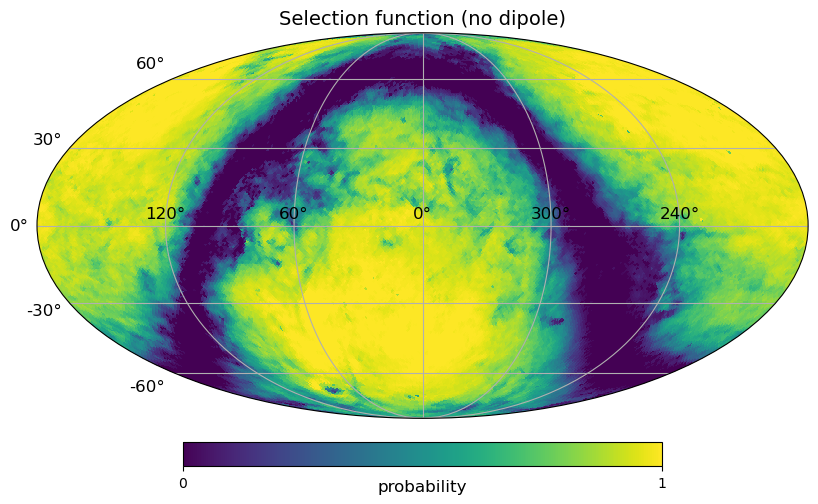

In [7]:
plot_map(selfunc_nodip, title='Selection function (no dipole)', unit='probability')

### selection function with dipole (only first few pixels fit)

In [8]:
nfit = 1000
sf_dip_tab = Table.read(os.path.join(mapdir, f'selection_function_NSIDE{NSIDE}_G{G}_dipole_{nfit}pix.fits'), format='fits')
selfunc_dip = flatten_map(sf_dip_tab)

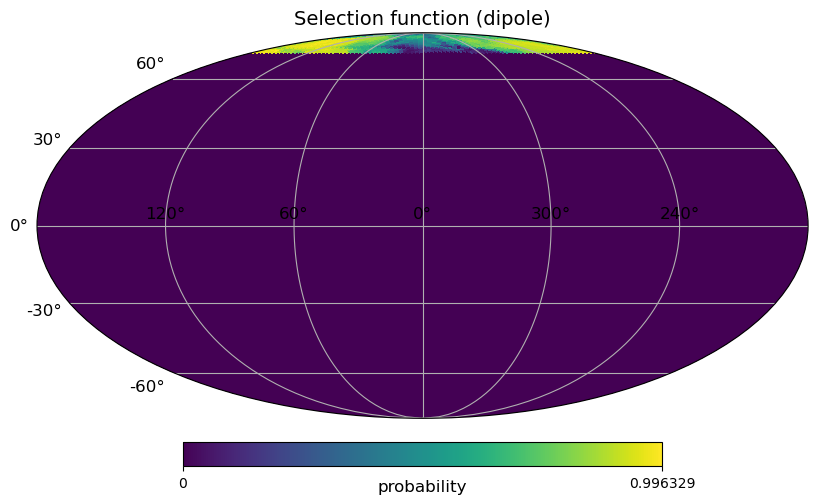

In [9]:
plot_map(selfunc_dip, title='Selection function (dipole)', unit='probability')

In [10]:
# residuals
res = selfunc_dip[:nfit] - selfunc_nodip[:nfit]

Text(0.5, 1.0, 'Selection function (dipole - no dipole) (first 1000 pixels)')

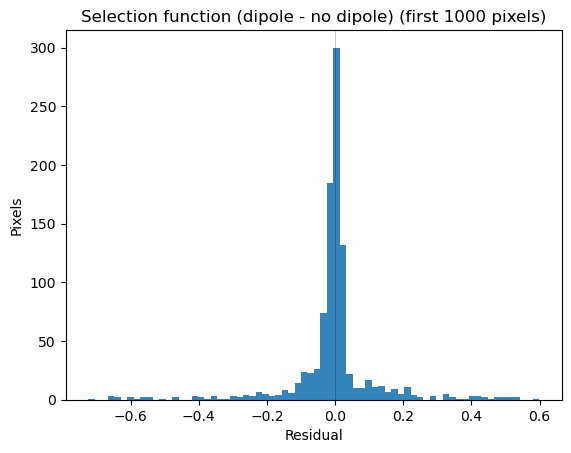

In [12]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(res, bins=70, alpha=0.9)
ax.axvline(0, color='k', lw=0.5, alpha=0.3)
ax.set_xlabel('Residual')
ax.set_ylabel('Pixels')
ax.set_title(f'Selection function (dipole - no dipole) (first {nfit} pixels)')